# Análisis de las acciones de los usuarios con las tarjetas

#### Hecho por David Gavilanes de Dios

#### Primero importamos las librerías necesarias

In [1]:
import pandas as pd
import json
from collections import defaultdict
import re
import numpy as np

#### Con este bucle obtenemos los datos necesarios de cada traza

In [2]:
#def porDefecto():
    #return defaultdict(lambda: {"tarjetasCreadas" : 0})

def extraerDatosTarjetas(rawData):
    erGameObject = re.compile(r'\bgame-object$\b')
    erInteracted = re.compile(r'\binteracted$\b')
    erCompleted = re.compile(r'\bcompleted$\b')
    erInitialized = re.compile(r'\binitialized$\b')
    erLevel = re.compile(r'\blevel$\b')
    erIdLevel = re.compile(r'/')
    
    dataCreadas = defaultdict(defaultdict)
    dataMovidas = defaultdict(defaultdict)
    dataEliminadas = defaultdict(defaultdict)
    dataAttach = defaultdict(defaultdict)
    dataDettach = defaultdict(defaultdict)
    dataDuplicate = defaultdict(defaultdict)
    dataDeclare = defaultdict(defaultdict)

    nivel = defaultdict()

    #Para cada traza...
    for evento in rawData:
        
        #print(evento)
        #Guardamos el verbo y el objeto de la traza
        verb = evento["verb"]["id"]
        obj = evento["object"]["definition"]["type"]
        levelCode = 0

        #Empezamos nivel y lo guardamos para luego mirar si es el editor level
        if erLevel.search(obj) and erInitialized.search(verb):
            if "result" in evento:
                name = evento["actor"]["name"]
                levelCode = erIdLevel.split(evento["object"]["id"])[-1]
                nivel[name] = levelCode

        #Si el objeto de la acción es un objecto
        elif erGameObject.search(obj) :
            name = evento["actor"]["name"]

            #Si el verbo es interacted...
            if erInteracted.search(verb):
                    
                    #Con try-catch evitamos errores de si una traza tiene el verbo y objeto que buscamos pero no es la traza propia que queremos analizar, ya que hay muchas con el mismo verbo y objeto
                    try:
                        #Descartamos el editor level
                        if nivel[name] != "editor_level":
                            
                                #Guardamos el bloque y la accion y cada una se guarda en un diccionario
                                bloque = evento["result"]["extensions"]["block_type"]
                                accion = evento["result"]["extensions"]["action"]
                                levelCode = nivel[name]

                                if accion == "create":
                                    if levelCode not in dataCreadas[name]:
                                        dataCreadas[name][levelCode] = defaultdict()
                                        
                                    if bloque in dataCreadas[name][levelCode]:
                                            dataCreadas[name][levelCode][bloque] += 1
                                    else:
                                        dataCreadas[name][levelCode][bloque] = 1

                                elif accion == "move":
                                    if levelCode not in dataMovidas[name]:
                                        dataMovidas[name][levelCode] = defaultdict()
 
                                    if evento["result"]["extensions"]["block_type"] in dataMovidas[name][levelCode]:
                                            dataMovidas[name][levelCode][bloque] += 1
                                    else:
                                        dataMovidas[name][levelCode][bloque] = 1

                                elif accion == "remove":
                                    if levelCode not in dataEliminadas[name]:
                                        dataEliminadas[name][levelCode] = defaultdict()
                                    if evento["result"]["extensions"]["block_type"] in dataEliminadas[name][levelCode]:
                                            dataEliminadas[name][levelCode][bloque] += 1
                                    else:
                                        dataEliminadas[name][levelCode][bloque] = 1

                                elif accion == "attach" or accion == "attach_to_input" or accion == "attach_to_bottom" or accion == "attach_to_top":
                                    if levelCode not in dataAttach[name]:
                                        dataAttach[name][levelCode] = defaultdict()
                                    if evento["result"]["extensions"]["block_type"] in dataAttach[name][levelCode]:
                                            dataAttach[name][levelCode][bloque] += 1
                                    else:
                                        dataAttach[name][levelCode][bloque] = 1
                                
                                elif accion == "dettach":
                                    if levelCode not in dataDettach[name]:
                                        dataDettach[name][levelCode] = defaultdict()
                                    if evento["result"]["extensions"]["block_type"] in dataDettach[name][levelCode]:
                                            dataDettach[name][levelCode][bloque] += 1
                                    else:
                                        dataDettach[name][levelCode][bloque] = 1

                                elif accion == "duplicate":
                                    if levelCode not in dataDuplicate[name]:
                                        dataDuplicate[name][levelCode] = defaultdict()
                                    if evento["result"]["extensions"]["block_type"] in dataDuplicate[name][levelCode]:
                                            dataDuplicate[name][levelCode][bloque] += 1
                                    else:
                                        dataDuplicate[name][levelCode][bloque] = 1
                        
                                elif accion == "declare":
                                    if levelCode not in dataDeclare[name]:
                                        dataDeclare[name][levelCode] = defaultdict()
                                    if evento["result"]["extensions"]["block_type"] in dataDeclare[name][levelCode]:
                                        dataDeclare[name][levelCode][bloque] += 1
                                    else:
                                        dataDeclare[name][levelCode][bloque] = 1

                    except KeyError:
                        pass               

    return dataCreadas, dataMovidas, dataEliminadas, dataAttach, dataDettach, dataDuplicate, dataDeclare 

In [3]:
#Al haber guardado en cada diccionario cada tipo de accion y el numero de veces que aparece, ahora hacemos la media de cada accion en cada nivel y para cada bloque
def mediaTarjetas(data):
    mediaTarjeta = defaultdict(defaultdict)
    numero = defaultdict(defaultdict)
    listaValores = defaultdict(defaultdict)

    for name in data:
        for level in data[name]:
            for bloque in data[name][level]:
                if bloque in mediaTarjeta[level]:
                    mediaTarjeta[level][bloque] += data[name][level][bloque]
                    numero[level][bloque] += 1
                    listaValores[level][bloque].append(data[name][level][bloque])
                else:
                    mediaTarjeta[level][bloque] = data[name][level][bloque]
                    numero[level][bloque] = 1
                    listaValores[level][bloque] = [data[name][level][bloque]]

    for level in mediaTarjeta:
        for bloque in mediaTarjeta[level]:
            mediaTarjeta[level][bloque] = mediaTarjeta[level][bloque] / numero[level][bloque]
    
    return mediaTarjeta, listaValores
            
            

                

In [4]:
#Aqui mostramos los datos y abrimos los json
JSONFile = open('./Back/data/traces_Articoding_Escolapias.json')
rawData = json.load(JSONFile)
dataCreadas, dataMovidas, dataEliminadas, dataAttach, dataDettach, dataDuplicate, dataDeclare = extraerDatosTarjetas(rawData)

pd.DataFrame(dataCreadas)

JSONFile.close()

pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
#pd.DataFrame(data)

for e in rawData:
    if e["actor"]["name"] == "gqoj":
        #print(e)
        #print("-----------------------------------------------------------------")
        None

pd.DataFrame(dataCreadas)

#Si aparece nan es un 0 y comprobar editor_level
#getUltimoNivelAlcanzado y getMediaTiempoPorNivel para hacer ratio de errores y nivel alcanzado
#quitar niveles de tutorials
#hacer clustering de niveles.
#probaar crear y borrar o todos

gqoj  \
tutorials_2        {'procedures_callnoreturn': 2, 'procedures_callreturn': 1, 'procedures_defreturn': 2, 'procedures_defnoreturn': 1, 'start_start': 1}   
variables_3                                                                                                                          {'math_number': 1}   
variables_4                                                                                                                        {'variables_get': 1}   
variables_5                                                                                                                                         NaN   
variables_6                                                                                                                                         NaN   
variables_7                                                                                                                                         NaN   
variables_8                                                                                                                                         NaN   
variables_9                                                                                                                                         NaN   
types_1                                                                                                                                             NaN   
types_2                                                                                                                                             NaN   
types_3                                                                                                                                             NaN   
types_4                                                                                                                                             NaN   
types_5                                                                                                                                             NaN   
types_6                                                                                                                                             NaN   
types_7                                                                                                                                             NaN   
types_8                                                                                                                                             NaN   
types_9                                                                                                                                             NaN   
basic_operators_2                                                                                                                                   NaN   
basic_operators_3                                                                                                                                   NaN   
basic_operators_4                                                                                                                                   NaN   
basic_operators_5                                                                                                                                   NaN   
basic_operators_6                                                                                                                                   NaN   
basic_operators_7                                                                                                                                   NaN   
loops_1                                                                                                                                             NaN   
loops_2                                                                                                                                             NaN   
loops_3                                                                                                              

In [5]:
mediaCreadas, listaCreadas = mediaTarjetas(dataCreadas)
pd.DataFrame(mediaCreadas)

tutorials_2  variables_3  variables_4  \
procedures_callnoreturn                  2.0          NaN          NaN   
procedures_callreturn                    1.0          NaN          NaN   
procedures_defreturn                     2.0          NaN          NaN   
procedures_defnoreturn                   1.0          NaN          NaN   
start_start                              1.0          NaN     1.000000   
math_number                              NaN     1.170213          NaN   
movement_move_laser                      NaN     2.000000          NaN   
variables_get                            NaN     3.000000     2.304348   
movement_rotate_laser                    NaN     1.000000          NaN   
variables_set                            NaN          NaN     1.600000   
logic_ifelse                             NaN          NaN     1.000000   
math_arithmetic                          NaN          NaN     1.000000   
movement_rotate                          NaN          NaN          NaN   
movement_move                            NaN          NaN          NaN   
movement_laser_change_intensity          NaN          NaN          NaN   
text                                     NaN          NaN          NaN   
movement_activate_door                   NaN          NaN          NaN   
logic_boolean                            NaN          NaN          NaN   
logic_compare                            NaN          NaN          NaN   
logic_cells_occupied                     NaN          NaN          NaN   
logic_negate                             NaN          NaN          NaN   

                                 variables_5  variables_6  variables_7  \
procedures_callnoreturn                  NaN          NaN          NaN   
procedures_callreturn                    NaN          NaN          NaN   
procedures_defreturn                     NaN          NaN          NaN   
procedures_defnoreturn                   NaN          NaN          NaN   
start_start                              NaN          NaN     1.000000   
math_number                         1.718519     1.236111          NaN   
movement_move_laser                 1.000000     2.512397     2.708661   
variables_get                       5.748148     3.382812     3.881890   
movement_rotate_laser               1.000000     1.176923     1.119048   
variables_set                       2.472441     1.321429     1.222222   
logic_ifelse                             NaN          NaN          NaN   
math_arithmetic                          NaN          NaN          NaN   
movement_rotate                          NaN     1.000000          NaN   
movement_move                            NaN          NaN          NaN   
movement_laser_change_intensity          NaN          NaN          NaN   
text                                     NaN          NaN          NaN   
movement_activate_door                   NaN          NaN          NaN   
logic_boolean                            NaN          NaN          NaN   
logic_compare                            NaN          NaN          NaN   
logic_cells_occupied                     NaN          NaN          NaN   
logic_negate                             NaN          NaN          NaN   

                                 variables_8  variables_9   types_1   types_2  \
procedures_callnoreturn                  NaN          NaN       NaN       NaN   
procedures_callreturn                    NaN          NaN       NaN       NaN   
procedures_defreturn                     NaN          NaN       NaN       NaN   
procedures_defnoreturn                   NaN          NaN       NaN       NaN   
start_start                              NaN     1.000000       NaN       NaN   
math_number                         1.084746     1.000000       NaN  1.072072   
movement_move_laser                 1.421053     2.473684  1.175439       NaN   
variables_get                       3.310924     3.566372  2.192982  1.379310   
movement_rotate_laser                    NaN  

In [6]:
#ahora calculamos los outliers, que son aquellos que están por encima del tercer cuartil respecto a la media
def Outliers(data, lista):

    outliers = defaultdict(defaultdict)
    valores = defaultdict(defaultdict)
    
    for name in data:
        for level in data[name]:
            for bloque in data[name][level]:
                lista[level][bloque].sort(key=lambda x: x)
                q3=np.quantile(lista[level][bloque], 0.75)
                q1=np.quantile(lista[level][bloque], 0.25)
                if data[name][level][bloque] > q3+(1.5*(q3-q1)):
                    if level in outliers[name]:
                        outliers[name][level].append({bloque : str(data[name][level][bloque])})
                        valores[name][level] += data[name][level][bloque]
                    else:
                        outliers[name][level] = [{bloque + ": " + str(data[name][level][bloque])}]
                        valores[name][level] = data[name][level][bloque]

    return outliers, valores

In [7]:
outliersCreadas, valoresCreadas = Outliers(dataCreadas, listaCreadas)
pd.DataFrame(outliersCreadas)

eprdu                 gcpze  \
variables_8        [{variables_get: 4}]                   NaN   
types_5                             NaN  [{movement_move: 2}]   
variables_6                         NaN                   NaN   
types_8                             NaN                   NaN   
variables_7                         NaN                   NaN   
types_9                             NaN                   NaN   
types_3                             NaN                   NaN   
types_4                             NaN                   NaN   
types_6                             NaN                   NaN   
types_7                             NaN                   NaN   
variables_5                         NaN                   NaN   
basic_operators_5                   NaN                   NaN   
basic_operators_2                   NaN                   NaN   
types_2                             NaN                   NaN   
variables_4                         NaN                   NaN   
variables_3                         NaN                   NaN   
types_1                             NaN                   NaN   
variables_9                         NaN                   NaN   
basic_operators_4                   NaN                   NaN   
basic_operators_6                   NaN                   NaN   
basic_operators_3                   NaN                   NaN   

                                  loemd  \
variables_8          [{math_number: 2}]   
types_5                             NaN   
variables_6        [{variables_set: 2}]   
types_8            [{variables_set: 3}]   
variables_7                         NaN   
types_9                             NaN   
types_3                             NaN   
types_4                             NaN   
types_6                             NaN   
types_7                             NaN   
variables_5                         NaN   
basic_operators_5                   NaN   
basic_operators_2                   NaN   
types_2                             NaN   
variables_4                         NaN   
variables_3                         NaN   
types_1                             NaN   
variables_9                         NaN   
basic_operators_4                   NaN   
basic_operators_6                   NaN   
basic_operators_3                   NaN   

                                                                                                   qeqyj  \
variables_8                                                                         [{variables_set: 2}]   
types_5            [{variables_set: 5}, {'text': '7'}, {'movement_move': '3'}, {'movement_rotate': '3'}]   
variables_6                                                                                          NaN   
types_8                                                                                              NaN   
variables_7                                                                         [{variables_set: 2}]   
types_9                                                                             [{logic_boolean: 2}]   
types_3                                                                                              NaN   
types_4                                                                                              NaN   
types_6                                                                                              NaN   
types_7                                                                                              NaN   
variables_5                                                                                          NaN   
basic_operators_5                                                                                    NaN   
basic_operators_2                                                                                    NaN   
types_2                                                                                              NaN   
variables_4                         

In [8]:
#Ahora tenemos en cuenta el numero de outliers y hacemos un ranking de los niveles con outliers por encima de la media
def niveles(valores):
    levels = defaultdict()
    levels2 = defaultdict()
    final = defaultdict()

    for name in valores:
        for level in valores[name]:
            if level in levels:
                levels[level] += valores[name][level]
            else:
                levels[level] = valores[name][level]
    
    media = 0
    for level in levels:
        media += levels[level]
    media = media / len(levels.items())

    for level in levels:
        if levels[level] >= media:
                levels2[level] = levels[level]

    final = sorted(levels2.items(), key=lambda x: x[1])

    return final

In [9]:
nivelesCreadas = niveles(valoresCreadas)
pd.DataFrame(nivelesCreadas)

0    1
0            types_1  125
1  basic_operators_2  132
2        variables_9  153
3            types_3  183
4        variables_6  185
5            types_5  192
6        variables_7  196
7        variables_8  218
8        variables_5  325
9            types_4  362

In [10]:
pd.DataFrame(dataMovidas)

gqoj  \
tutorials_2        {'procedures_callnoreturn': 2, 'procedures_callreturn': 1, 'procedures_defreturn': 2, 'procedures_defnoreturn': 1, 'start_start': 1}   
tutorials_4                                                                                                                                         NaN   
variables_4                                                                                                                                         NaN   
variables_6                                                                                                                                         NaN   
variables_7                                                                                                                                         NaN   
variables_8                                                                                                                                         NaN   
types_3                                                                                                                                             NaN   
types_4                                                                                                                                             NaN   
types_5                                                                                                                                             NaN   
types_7                                                                                                                                             NaN   
types_8                                                                                                                                             NaN   
types_9                                                                                                                                             NaN   
variables_5                                                                                                                                         NaN   
variables_9                                                                                                                                         NaN   
types_2                                                                                                                                             NaN   
types_6                                                                                                                                             NaN   
variables_2                                                                                                                                         NaN   
variables_3                                                                                                                                         NaN   
types_1                                                                                                                                             NaN   
basic_operators_2                                                                                                                                   NaN   
basic_operators_3                                                                                                                                   NaN   
basic_operators_4                                                                                                                                   NaN   
basic_operators_7                                                                                                                                   NaN   
loops_3                                                                                                                                             NaN   
basic_operators_5                                                                                                                                   NaN   
loops_1                                                                                                              

In [11]:
mediaMovidas, listaMovidas = mediaTarjetas(dataMovidas)
pd.DataFrame(mediaMovidas)

tutorials_2  tutorials_4  variables_4  \
procedures_callnoreturn                  2.0          NaN          NaN   
procedures_callreturn                    1.0          NaN          NaN   
procedures_defreturn                     2.0          NaN          NaN   
procedures_defnoreturn                   1.0          NaN          NaN   
start_start                              1.0     1.000000     1.500000   
movement_move_laser                      1.0     1.333333     1.250000   
variables_set                            NaN     1.000000     2.285714   
variables_get                            NaN          NaN     2.295082   
math_number                              NaN          NaN     1.000000   
math_arithmetic                          NaN          NaN     1.000000   
movement_rotate_laser                    NaN          NaN     1.000000   
text                                     NaN          NaN          NaN   
movement_move                            NaN          NaN          NaN   
movement_rotate                          NaN          NaN          NaN   
movement_activate_door                   NaN          NaN          NaN   
logic_boolean                            NaN          NaN          NaN   
movement_laser_change_intensity          NaN          NaN          NaN   
logic_compare                            NaN          NaN          NaN   
logic_cells_occupied                     NaN          NaN          NaN   
logic_negate                             NaN          NaN          NaN   

                                 variables_6  variables_7  variables_8  \
procedures_callnoreturn                  NaN          NaN          NaN   
procedures_callreturn                    NaN          NaN          NaN   
procedures_defreturn                     NaN          NaN          NaN   
procedures_defnoreturn                   NaN          NaN          NaN   
start_start                         1.444444     1.875000     2.666667   
movement_move_laser                 1.625000     1.942857     1.818182   
variables_set                       2.600000     2.083333     1.666667   
variables_get                       2.756757     1.518519     2.357143   
math_number                         1.578947     1.333333     1.437500   
math_arithmetic                          NaN          NaN          NaN   
movement_rotate_laser               1.187500     1.352941     2.000000   
text                                     NaN     2.000000          NaN   
movement_move                            NaN          NaN          NaN   
movement_rotate                          NaN          NaN          NaN   
movement_activate_door                   NaN          NaN          NaN   
logic_boolean                            NaN          NaN          NaN   
movement_laser_change_intensity          NaN          NaN          NaN   
logic_compare                            NaN          NaN          NaN   
logic_cells_occupied                     NaN          NaN          NaN   
logic_negate                             NaN          NaN          NaN   

                                  types_3   types_4   types_5   types_7  \
procedures_callnoreturn               NaN       NaN       NaN       NaN   
procedures_callreturn                 NaN       NaN       NaN       NaN   
procedures_defreturn                  NaN       NaN       NaN       NaN   
procedures_defnoreturn                NaN       NaN       NaN       NaN   
start_start                      1.166667  1.333333  1.428571  1.000000   
movement_move_laser                   NaN       NaN       NaN       NaN   
variables_set                    2.230769  2.500000  1.969697  1.846154   
variables_get                    1.966102  2.131148  2.051282  2.105263   
math_number                      1.440000  1.666667  2.210526  1.166667   
math_arithmetic                       NaN       NaN       NaN       NaN   
movement_rotate_laser                 NaN       NaN       NaN       NaN   
text                   

In [12]:
outliersMovidas, valoresMovidas = Outliers(dataMovidas, listaMovidas)
pd.DataFrame(outliersMovidas)

kmqou                       gcpze  \
types_2            [{variables_get: 2}]                         NaN   
variables_9                         NaN  [{movement_move_laser: 5}]   
variables_5                         NaN                         NaN   
variables_6                         NaN                         NaN   
types_3                             NaN                         NaN   
basic_operators_2                   NaN                         NaN   
variables_7                         NaN                         NaN   
types_7                             NaN                         NaN   
types_1                             NaN                         NaN   
types_9                             NaN                         NaN   
types_4                             NaN                         NaN   
types_5                             NaN                         NaN   
types_8                             NaN                         NaN   
types_6                             NaN                         NaN   
variables_8                         NaN                         NaN   
basic_operators_3                   NaN                         NaN   
basic_operators_4                   NaN                         NaN   
variables_4                         NaN                         NaN   

                                   bdwyj                       ikcar  \
types_2               [{math_number: 2}]                         NaN   
variables_9         [{variables_get: 9}]                         NaN   
variables_5        [{variables_get: 11}]                         NaN   
variables_6        [{variables_set: 22}]  [{movement_move_laser: 4}]   
types_3             [{variables_set: 6}]                         NaN   
basic_operators_2                    NaN                         NaN   
variables_7                          NaN                         NaN   
types_7                              NaN                         NaN   
types_1                              NaN                         NaN   
types_9                              NaN                         NaN   
types_4                              NaN                         NaN   
types_5                              NaN                         NaN   
types_8                              NaN                         NaN   
types_6                              NaN                         NaN   
variables_8                          NaN                         NaN   
basic_operators_3                    NaN                         NaN   
basic_operators_4                    NaN                         NaN   
variables_4                          NaN                         NaN   

                                           srjon                       ejeuw  \
types_2                                      NaN                         NaN   
variables_9                                  NaN                         NaN   
variables_5                [{variables_set: 11}]                         NaN   
variables_6                                  NaN                         NaN   
types_3                                      NaN                         NaN   
basic_operators_2  [{movement_activate_door: 4}]                         NaN   
variables_7                                  NaN  [{movement_move_laser: 6}]   
types_7                                      NaN                         NaN   
types_1                                      NaN                         NaN   
types_9                                      NaN                         NaN   
types_4                                      NaN                         NaN   
types_5                                      NaN                         NaN   
types_8                                      NaN                         NaN   
types_6                                      NaN                         NaN   
variables_8                                  NaN                         NaN   
basic_operators_3                  

In [13]:
nivelesMovidas = niveles(valoresMovidas)
pd.DataFrame(nivelesMovidas)

0    1
0      types_4   55
1  variables_9   58
2  variables_5   75
3  variables_6  102
4      types_3  112

In [14]:
pd.DataFrame(dataEliminadas)

gqoj  \
tutorials_2        {'procedures_callnoreturn': 1, 'procedures_callreturn': 1, 'procedures_defreturn': 1, 'procedures_defnoreturn': 1}   
variables_4                                                                                                                       NaN   
variables_5                                                                                                                       NaN   
variables_9                                                                                                                       NaN   
types_3                                                                                                                           NaN   
types_5                                                                                                                           NaN   
types_9                                                                                                                           NaN   
basic_operators_4                                                                                                                 NaN   
loops_3                                                                                                                           NaN   
variables_6                                                                                                                       NaN   
variables_7                                                                                                                       NaN   
variables_8                                                                                                                       NaN   
basic_operators_2                                                                                                                 NaN   
basic_operators_5                                                                                                                 NaN   
basic_operators_6                                                                                                                 NaN   
types_8                                                                                                                           NaN   
types_4                                                                                                                           NaN   
types_6                                                                                                                           NaN   
types_7                                                                                                                           NaN   
variables_2                                                                                                                       NaN   
tutorials_6                                                                                                                       NaN   
tutorials_7                                                                                                                       NaN   
types_2                                                                                                                           NaN   
types_1                                                                                                                           NaN   
variables_3                                                                                                                       NaN   
loops_1                                                                                                                           NaN   
tutorials_4                                                                                                                       NaN   
variables_1                                                                                                                       NaN   
basic_operators_3                                                                                                                 NaN   
loops_4            

In [15]:
mediaEliminadas, listaEliminadas = mediaTarjetas(dataEliminadas)
pd.DataFrame(mediaEliminadas)

tutorials_2  variables_4  variables_5  variables_9  \
procedures_callnoreturn          1.0          NaN          NaN          NaN   
procedures_callreturn            1.0          NaN          NaN          NaN   
procedures_defreturn             1.0          NaN          NaN          NaN   
procedures_defnoreturn           1.0          NaN          NaN          NaN   
variables_get                    NaN     2.436364     2.176471     1.333333   
variables_set                    NaN     1.744186     1.815385     1.321429   
math_number                      NaN     1.000000     1.000000     1.000000   
movement_move_laser              NaN          NaN     1.000000     1.000000   
start_start                      NaN          NaN     1.000000     1.000000   
movement_rotate_laser            NaN          NaN          NaN     1.000000   
text                             NaN          NaN          NaN          NaN   
movement_move                    NaN          NaN          NaN          NaN   
movement_rotate                  NaN          NaN          NaN          NaN   
logic_boolean                    NaN          NaN          NaN          NaN   
movement_activate_door           NaN          NaN          NaN          NaN   
math_arithmetic                  NaN          NaN          NaN          NaN   
logic_compare                    NaN          NaN          NaN          NaN   

                          types_3   types_5   types_9  basic_operators_4  \
procedures_callnoreturn       NaN       NaN       NaN                NaN   
procedures_callreturn         NaN       NaN       NaN                NaN   
procedures_defreturn          NaN       NaN       NaN                NaN   
procedures_defnoreturn        NaN       NaN       NaN                NaN   
variables_get            1.783784  1.909091  2.857143           3.333333   
variables_set            1.406250  1.714286  1.200000           2.000000   
math_number              1.111111  1.000000       NaN                NaN   
movement_move_laser           NaN       NaN       NaN                NaN   
start_start              1.000000       NaN       NaN                NaN   
movement_rotate_laser         NaN       NaN       NaN                NaN   
text                     1.300000  1.434783  1.000000                NaN   
movement_move            1.083333  1.285714  1.000000           3.333333   
movement_rotate          1.058824  1.166667  1.000000                NaN   
logic_boolean                 NaN       NaN  1.000000                NaN   
movement_activate_door        NaN       NaN  1.000000                NaN   
math_arithmetic               NaN       NaN       NaN           1.000000   
logic_compare                 NaN       NaN       NaN                NaN   

                         loops_3  variables_6  variables_7  variables_8  \
procedures_callnoreturn      NaN          NaN          NaN          NaN   
procedures_callreturn        NaN          NaN          NaN          NaN   
procedures_defreturn         NaN          NaN          NaN          NaN   
procedures_defnoreturn       NaN          NaN          NaN          NaN   
variables_get                1.0     1.461538     1.400000     1.611111   
variables_set                1.0     1.388889     1.342105     1.375000   
math_number                  1.0     1.000000     1.500000     1.000000   
movement_move_laser          NaN     1.444444     1.000000     1.400000   
start_start                  NaN          NaN     1.000000          NaN   
movement_rotate_laser        NaN     1.166667     1.000000          NaN   
text                         NaN          NaN          NaN          NaN   
movement_move                NaN          NaN          NaN          NaN   
movement_rotate              NaN          NaN          NaN          NaN   
logic_boolean                NaN          NaN          NaN          NaN   
movement_activate_door       NaN          NaN          NaN          NaN   
math_arithmetic              NaN 

In [16]:
outliersEliminadas, valoresEliminadas = Outliers(dataEliminadas, listaEliminadas)
pd.DataFrame(outliersEliminadas)

qeqyj                 sxipu  \
variables_7        [{variables_set: 2}]                   NaN   
types_3                             NaN  [{variables_get: 4}]   
types_4                             NaN                   NaN   
types_7                             NaN                   NaN   
types_5                             NaN                   NaN   
variables_4                         NaN                   NaN   
variables_8                         NaN                   NaN   
variables_9                         NaN                   NaN   
basic_operators_3                   NaN                   NaN   
types_6                             NaN                   NaN   
basic_operators_2                   NaN                   NaN   
types_9                             NaN                   NaN   
variables_2                         NaN                   NaN   
variables_5                         NaN                   NaN   
types_1                             NaN                   NaN   
variables_6                         NaN                   NaN   
types_8                             NaN                   NaN   
types_2                             NaN                   NaN   
variables_3                         NaN                   NaN   

                                    uzzpo        ikcar  \
variables_7                           NaN          NaN   
types_3                               NaN          NaN   
types_4              [{variables_set: 4}]          NaN   
types_7            [{movement_rotate: 2}]          NaN   
types_5                               NaN  [{text: 3}]   
variables_4                           NaN          NaN   
variables_8                           NaN          NaN   
variables_9                           NaN          NaN   
basic_operators_3                     NaN          NaN   
types_6                               NaN          NaN   
basic_operators_2                     NaN          NaN   
types_9                               NaN          NaN   
variables_2                           NaN          NaN   
variables_5                           NaN          NaN   
types_1                               NaN          NaN   
variables_6                           NaN          NaN   
types_8                               NaN          NaN   
types_2                               NaN          NaN   
variables_3                           NaN          NaN   

                                               zxvkj                 epqkm  \
variables_7                                      NaN                   NaN   
types_3            [{text: 3}, {'math_number': '2'}]                   NaN   
types_4                                          NaN                   NaN   
types_7                                          NaN                   NaN   
types_5                         [{variables_get: 5}]                   NaN   
variables_4                                      NaN  [{variables_set: 4}]   
variables_8                                      NaN                   NaN   
variables_9                                      NaN                   NaN   
basic_operators_3                                NaN                   NaN   
types_6                                          NaN                   NaN   
basic_operators_2                                NaN                   NaN   
types_9                                          NaN                   NaN   
variables_2                                      NaN                   NaN   
variables_5                                      NaN                   NaN   
types_1                                          NaN                   NaN   
variables_6                                      NaN                   NaN   
types_8                                          NaN                   NaN   
types_2                                          NaN                   NaN   
variables_3                                      NaN                   NaN   

           

In [17]:
nivelesEliminadas = niveles(valoresEliminadas)
pd.DataFrame(nivelesEliminadas)

0   1
0  variables_3  20
1  variables_9  22
2      types_4  23
3  variables_7  26
4  variables_6  27
5      types_5  34
6  variables_4  35
7  variables_5  50
8      types_3  57

In [18]:
pd.DataFrame(dataAttach)

qeqyj  \
tutorials_2                                                                                                                          {'movement_move_laser': 4}   
tutorials_4                                                                                    {'movement_move_laser': 4, 'movement_laser_change_intensity': 2}   
variables_3                                                                                                                                  {'math_number': 1}   
variables_4                                                                {'variables_get': 7, 'math_number': 2, 'variables_set': 8, 'movement_move_laser': 4}   
variables_5                                                                                          {'variables_get': 4, 'variables_set': 1, 'math_number': 1}   
variables_6                                    {'variables_get': 6, 'variables_set': 2, 'math_number': 2, 'movement_move_laser': 3, 'movement_rotate_laser': 4}   
variables_7                                                      {'movement_move_laser': 7, 'variables_get': 5, 'variables_set': 2, 'movement_rotate_laser': 2}   
variables_8                                                                {'variables_set': 1, 'math_number': 1, 'movement_move_laser': 1, 'variables_get': 5}   
variables_9                                                      {'movement_move_laser': 3, 'variables_get': 3, 'movement_rotate_laser': 4, 'variables_set': 2}   
types_1                                                                              {'movement_rotate_laser': 2, 'variables_get': 2, 'movement_move_laser': 1}   
types_2                                                                                                                                      {'math_number': 1}   
types_3                                                    {'movement_move': 2, 'variables_set': 1, 'math_number': 1, 'variables_get': 9, 'movement_rotate': 1}   
types_4                                                    {'movement_rotate': 5, 'variables_set': 2, 'math_number': 1, 'variables_get': 8, 'movement_move': 3}   
types_5                                      {'movement_rotate': 7, 'variables_set': 5, 'movement_move': 10, 'text': 11, 'variables_get': 13, 'math_number': 1}   
types_6            {'movement_move': 1, 'variables_get': 5, 'math_number': 2, 'movement_rotate': 1, 'variables_set': 1, 'movement_activate_door': 1, 'text': 1}   
types_7                                {'variables_set': 4, 'text': 3, 'movement_move': 2, 'variables_get': 5, 'movement_activate_door': 1, 'logic_boolean': 1}   
types_8                                         {'variables_set': 3, 'math_number': 1, 'text': 1, 'movement_rotate': 2, 'variables_get': 6, 'movement_move': 1}   
types_9              {'movement_move': 4, 'variables_set': 2, 'math_number': 1, 'variables_get': 5, 'text': 1, 'movement_activate_door': 1, 'logic_boolean': 1}   
tutorials_1                                                                                                                                                 NaN   
tutorials_7                                                                                                                                                 NaN   
variables_2                                                                                                                                                 NaN   
basic_operators_2                                                                                                                                           NaN   
basic_operators_3                                                                                                                                           NaN   
basic_operators_4                                                                                                                                           NaN   
basic_operators_5                                                              

In [19]:
mediaAttach, listaAttach = mediaTarjetas(dataAttach)
pd.DataFrame(mediaAttach)

tutorials_2  tutorials_4  variables_3  \
movement_move_laser                      2.0     1.769231     1.636364   
movement_laser_change_intensity          NaN     1.375000          NaN   
variables_get                            NaN     2.000000     2.285714   
math_number                              NaN     2.333333     1.429577   
movement_rotate_laser                    NaN          NaN     1.454545   
variables_set                            NaN          NaN     2.000000   
logic_ifelse                             NaN          NaN          NaN   
start_start                              NaN          NaN          NaN   
movement_rotate                          NaN          NaN          NaN   
movement_move                            NaN          NaN          NaN   
text                                     NaN          NaN          NaN   
movement_activate_door                   NaN          NaN          NaN   
logic_boolean                            NaN          NaN          NaN   
logic_compare                            NaN          NaN          NaN   
math_arithmetic                          NaN          NaN          NaN   
logic_cells_occupied                     NaN          NaN          NaN   
logic_operation                          NaN          NaN          NaN   
logic_negate                             NaN          NaN          NaN   

                                 variables_4  variables_5  variables_6  \
movement_move_laser                 2.000000     2.408451     3.700000   
movement_laser_change_intensity          NaN          NaN          NaN   
variables_get                       2.427536     6.444444     3.492188   
math_number                         2.346154     3.044444     1.702703   
movement_rotate_laser               1.826087     2.025641     1.519380   
variables_set                       2.980769     3.788618     2.266667   
logic_ifelse                        1.000000          NaN          NaN   
start_start                         1.000000     1.111111     1.000000   
movement_rotate                          NaN          NaN     1.000000   
movement_move                            NaN          NaN          NaN   
text                                     NaN          NaN          NaN   
movement_activate_door                   NaN          NaN          NaN   
logic_boolean                            NaN          NaN          NaN   
logic_compare                            NaN          NaN          NaN   
math_arithmetic                          NaN          NaN          NaN   
logic_cells_occupied                     NaN          NaN          NaN   
logic_operation                          NaN          NaN          NaN   
logic_negate                             NaN          NaN          NaN   

                                 variables_7  variables_8  variables_9  \
movement_move_laser                 3.574803     1.590361     3.114035   
movement_laser_change_intensity          NaN          NaN          NaN   
variables_get                       4.086614     3.352941     3.831858   
math_number                         2.400000     1.449153     1.818182   
movement_rotate_laser               1.304000     1.666667     1.362832   
variables_set                       1.934426     1.696629     2.170732   
logic_ifelse                             NaN          NaN          NaN   
start_start                              NaN     1.500000     1.000000   
movement_rotate                          NaN     1.000000          NaN   
movement_move                            NaN     1.000000          NaN   
text                                     NaN          NaN          NaN   
movement_activate_door                   NaN          NaN          NaN   
logic_boolean                            NaN          NaN          NaN   
logic_compare                            NaN          NaN          NaN   
math_arithmetic                          NaN          NaN          NaN   
logic_cells_occupied               

In [20]:
outliersAttach, valoresAttach = Outliers(dataAttach, listaAttach)
pd.DataFrame(outliersAttach)

qeqyj  \
tutorials_4                                                                      [{movement_move_laser: 4}]   
variables_4                                                                            [{variables_get: 7}]   
variables_6                                                                    [{movement_rotate_laser: 4}]   
variables_7                                                                    [{movement_rotate_laser: 2}]   
variables_8                                                                            [{variables_get: 5}]   
variables_9                                                                    [{movement_rotate_laser: 4}]   
types_1                                                                        [{movement_rotate_laser: 2}]   
types_4                                                                              [{movement_rotate: 5}]   
types_5            [{movement_rotate: 7}, {'movement_move': '10'}, {'text': '11'}, {'variables_get': '13'}]   
types_6                                                                                                 NaN   
types_7                                                                                                 NaN   
types_8                                                                                                 NaN   
types_9                                                                                                 NaN   
basic_operators_5                                                                                       NaN   
loops_1                                                                                                 NaN   
loops_3                                                                                                 NaN   
basic_operators_7                                                                                       NaN   
types_3                                                                                                 NaN   
variables_5                                                                                             NaN   
basic_operators_2                                                                                       NaN   
types_2                                                                                                 NaN   
variables_3                                                                                             NaN   
tutorials_7                                                                                             NaN   
basic_operators_3                                                                                       NaN   
basic_operators_4                                                                                       NaN   
basic_operators_6                                                                                       NaN   
variables_2                                                                                             NaN   
loops_2                                                                                                 NaN   
tutorials_2                                                                                             NaN   
tutorials_6                                                                                             NaN   

                                                            kmqou  \
tutorials_4                                                   NaN   
variables_4                                                   NaN   
variables_6                                                   NaN   
variables_7                                                   NaN   
variables_8            [{variables_get: 7}, {'math_number': '3'}]   
variables_9                                                   NaN   
types_1                                                       NaN   
types_4                                                       NaN   
types_5                                

In [21]:
nivelesAttach = niveles(valoresAttach)
pd.DataFrame(nivelesAttach)

0    1
0       types_6  162
1       types_1  169
2       types_7  177
3   variables_9  256
4   variables_6  259
5   variables_8  281
6       types_5  288
7       types_3  292
8       types_4  320
9   variables_7  334
10  variables_5  410

In [22]:
pd.DataFrame(dataDettach)

qeqyj  \
tutorials_2                                                                           {'movement_move_laser': 2}   
tutorials_4                                     {'movement_move_laser': 3, 'movement_laser_change_intensity': 1}   
variables_4                                   {'movement_move_laser': 4, 'variables_get': 2, 'variables_set': 3}   
variables_5                                                                                 {'variables_get': 1}   
variables_6                 {'variables_get': 2, 'math_number': 1, 'variables_set': 3, 'movement_move_laser': 1}   
variables_7                           {'movement_move_laser': 3, 'variables_set': 2, 'movement_rotate_laser': 1}   
variables_8                                                                           {'movement_move_laser': 1}   
variables_9                           {'movement_rotate_laser': 2, 'movement_move_laser': 1, 'variables_set': 2}   
types_1                                                                             {'movement_rotate_laser': 1}   
types_3                                                                 {'movement_move': 1, 'variables_get': 1}   
types_4                                                               {'movement_rotate': 1, 'movement_move': 1}   
types_5            {'movement_move': 4, 'variables_set': 2, 'movement_rotate': 2, 'text': 2, 'variables_get': 1}   
types_6                                                        {'variables_get': 3, 'movement_activate_door': 1}   
types_7                                                                                     {'variables_set': 1}   
types_8                                                               {'movement_rotate': 1, 'variables_set': 1}   
types_9                                                                                     {'movement_move': 2}   
variables_2                                                                                                  NaN   
basic_operators_2                                                                                            NaN   
basic_operators_3                                                                                            NaN   
basic_operators_5                                                                                            NaN   
basic_operators_6                                                                                            NaN   
basic_operators_7                                                                                            NaN   
loops_1                                                                                                      NaN   
basic_operators_4                                                                                            NaN   
loops_3                                                                                                      NaN   
tutorials_5                                                                                                  NaN   
tutorials_7                                                                                                  NaN   
types_2                                                                                                      NaN   
tutorials_6                                                                                                  NaN   
variables_1                                                                                                  NaN   
variables_3                                                                                                  NaN   
loops_4                                                                                                      NaN   
basic_operators_1                                                                                            NaN   
tutorials_3                                                                                                  NaN   
tutorials_1                                    

In [23]:
mediaDettach, listaDettach = mediaTarjetas(dataDettach)
pd.DataFrame(mediaDettach)

tutorials_2  tutorials_4  variables_4  \
movement_move_laser                      2.0     1.428571     1.360000   
movement_laser_change_intensity          NaN     1.000000          NaN   
math_number                              NaN     1.000000     1.250000   
variables_get                            NaN          NaN     1.695652   
variables_set                            NaN          NaN     1.923077   
movement_rotate_laser                    NaN          NaN     1.300000   
movement_move                            NaN          NaN          NaN   
text                                     NaN          NaN          NaN   
movement_rotate                          NaN          NaN          NaN   
movement_activate_door                   NaN          NaN          NaN   
logic_boolean                            NaN          NaN          NaN   
logic_compare                            NaN          NaN          NaN   
math_arithmetic                          NaN          NaN          NaN   
logic_operation                          NaN          NaN          NaN   
logic_negate                             NaN          NaN          NaN   

                                 variables_5  variables_6  variables_7  \
movement_move_laser                 1.653061     1.574468     1.738095   
movement_laser_change_intensity          NaN          NaN          NaN   
math_number                         1.476190     1.400000     1.600000   
variables_get                       1.696429     1.333333     1.473684   
variables_set                       1.959459     1.647887     1.333333   
movement_rotate_laser               1.281250     1.388889     1.000000   
movement_move                            NaN          NaN          NaN   
text                                     NaN          NaN          NaN   
movement_rotate                          NaN          NaN          NaN   
movement_activate_door                   NaN          NaN          NaN   
logic_boolean                            NaN          NaN          NaN   
logic_compare                            NaN          NaN          NaN   
math_arithmetic                          NaN          NaN          NaN   
logic_operation                          NaN          NaN          NaN   
logic_negate                             NaN          NaN          NaN   

                                 variables_8  variables_9   types_1   types_3  \
movement_move_laser                 1.225000     1.333333  1.187500       NaN   
movement_laser_change_intensity          NaN          NaN       NaN       NaN   
math_number                         1.250000     1.250000  1.000000  1.294118   
variables_get                       1.400000     1.142857  1.250000  1.771429   
variables_set                       1.500000     1.636364  1.238095  1.657895   
movement_rotate_laser               1.258065     1.200000  1.071429  1.000000   
movement_move                            NaN          NaN       NaN  1.410256   
text                                     NaN          NaN       NaN  1.488372   
movement_rotate                          NaN          NaN       NaN  1.290323   
movement_activate_door                   NaN          NaN       NaN       NaN   
logic_boolean                            NaN          NaN       NaN       NaN   
logic_compare                            NaN          NaN       NaN       NaN   
math_arithmetic                          NaN          NaN       NaN       NaN   
logic_operation                          NaN          NaN       NaN       NaN   
logic_negate                             NaN          NaN       NaN       NaN   

                                  types_4   types_5  types_6   types_7  \
movement_move_laser                   NaN       NaN      NaN       NaN   
movement_laser_change_intensity       NaN       NaN      NaN       NaN   
math_number                      1.344828  1.153846      1.0  1.000000   
variables_get                    1.666667  1.538462      2.0  1.000000

In [24]:
outliersDettach, valoresDettach = Outliers(dataDettach, listaDettach)
pd.DataFrame(outliersDettach)

qeqyj  \
tutorials_4                            [{movement_move_laser: 3}]   
variables_4                            [{movement_move_laser: 4}]   
variables_7                                  [{variables_set: 2}]   
variables_9                          [{movement_rotate_laser: 2}]   
types_5            [{movement_move: 4}, {'movement_rotate': '2'}]   
variables_2                                                   NaN   
types_9                                                       NaN   
types_6                                                       NaN   
basic_operators_2                                             NaN   
variables_5                                                   NaN   
types_7                                                       NaN   
types_1                                                       NaN   
variables_8                                                   NaN   
types_2                                                       NaN   
basic_operators_3                                             NaN   
types_3                                                       NaN   
types_4                                                       NaN   
types_8                                                       NaN   
variables_6                                                   NaN   
basic_operators_4                                             NaN   
variables_3                                                   NaN   

                                  loemd  \
tutorials_4                         NaN   
variables_4                         NaN   
variables_7                         NaN   
variables_9                         NaN   
types_5                             NaN   
variables_2        [{variables_get: 2}]   
types_9                             NaN   
types_6                             NaN   
basic_operators_2                   NaN   
variables_5                         NaN   
types_7                             NaN   
types_1                             NaN   
variables_8                         NaN   
types_2                             NaN   
basic_operators_3                   NaN   
types_3                             NaN   
types_4                             NaN   
types_8                             NaN   
variables_6                         NaN   
basic_operators_4                   NaN   
variables_3                         NaN   

                                                                   gcpze  \
tutorials_4                                                          NaN   
variables_4                                                          NaN   
variables_7                                                          NaN   
variables_9                                                          NaN   
types_5                                                              NaN   
variables_2                                                          NaN   
types_9            [{movement_activate_door: 2}, {'variables_set': '2'}]   
types_6                                                              NaN   
basic_operators_2                                                    NaN   
variables_5                                                          NaN   
types_7                                                              NaN   
types_1                                                              NaN   
variables_8                                                          NaN   
types_2                                                              NaN   
basic_operators_3                                                    NaN   
types_3                                                              NaN   
types_4                                                              NaN   
types_8                                                              NaN   
variables_6                                                          NaN   
basic_operators_4                                                    NaN  

In [25]:
nivelesDettach = niveles(valoresDettach)
pd.DataFrame(nivelesDettach)

0    1
0      types_5   30
1  variables_4   36
2      types_4   42
3  variables_8   44
4  variables_7   53
5  variables_6   53
6      types_3   59
7  variables_5  115

In [26]:
pd.DataFrame(dataDuplicate)

gcpze  \
variables_7                        {'movement_move_laser': 1}   
variables_9                        {'movement_move_laser': 2}   
types_4            {'movement_move': 1, 'movement_rotate': 1}   
types_5            {'movement_rotate': 1, 'movement_move': 1}   
types_7                                  {'movement_move': 1}   
types_8                                {'movement_rotate': 1}   
types_9                                  {'movement_move': 1}   
loops_1                                  {'movement_move': 3}   
variables_6                                               NaN   
variables_4                                               NaN   
basic_operators_4                                         NaN   
loops_3                                                   NaN   
variables_8                                               NaN   
types_1                                                   NaN   
types_2                                                   NaN   
types_3                                                   NaN   
basic_operators_3                                         NaN   
tutorials_7                                               NaN   
types_6                                                   NaN   
basic_operators_2                                         NaN   
basic_operators_7                                         NaN   
loops_2                                                   NaN   
variables_3                                               NaN   
variables_5                                               NaN   

                                        khadt                 epqkm  \
variables_7                               NaN                   NaN   
variables_9                               NaN                   NaN   
types_4                                   NaN                   NaN   
types_5                                   NaN                   NaN   
types_7                                   NaN                   NaN   
types_8                                   NaN                   NaN   
types_9                                   NaN                   NaN   
loops_1                                   NaN                   NaN   
variables_6        {'movement_move_laser': 2}                   NaN   
variables_4                               NaN  {'variables_set': 1}   
basic_operators_4                         NaN                   NaN   
loops_3                                   NaN                   NaN   
variables_8                               NaN                   NaN   
types_1                                   NaN                   NaN   
types_2                                   NaN                   NaN   
types_3                                   NaN                   NaN   
basic_operators_3                         NaN                   NaN   
tutorials_7                               NaN                   NaN   
types_6                                   NaN                   NaN   
basic_operators_2                         NaN                   NaN   
basic_operators_7                         NaN                   NaN   
loops_2                                   NaN                   NaN   
variables_3                               NaN                   NaN   
variables_5                               NaN                   NaN   

                                        eprdu                       cmbfi  \
variables_7        {'movement_move_laser': 2}                         NaN   
variables_9        {'movement_move_laser': 2}                         NaN   
types_4                                   NaN                         NaN   
types_5                                   NaN                         NaN   
types_7                  {'movement_move': 1}                         NaN   
types_8                                   NaN                         NaN   
types_9                                   NaN                         NaN   
loops_1                  {'movement_mo

In [27]:
mediaDuplicate, listaDuplicate = mediaTarjetas(dataDuplicate)
pd.DataFrame(mediaDuplicate)

variables_7  variables_9  types_4   types_5   types_7  \
movement_move_laser           1.75     1.444444      NaN       NaN       NaN   
variables_get                 1.00     2.666667     3.50  3.333333  1.333333   
variables_set                 1.00     1.000000      NaN  2.000000  2.500000   
movement_move                  NaN          NaN     1.25  1.250000  1.000000   
movement_rotate                NaN          NaN     1.00  1.000000       NaN   
text                           NaN          NaN      NaN  1.571429  1.500000   
math_number                    NaN          NaN      NaN       NaN       NaN   
movement_rotate_laser          NaN          NaN      NaN       NaN       NaN   
math_arithmetic                NaN          NaN      NaN       NaN       NaN   

                        types_8  types_9   loops_1  variables_6  variables_4  \
movement_move_laser         NaN      NaN       NaN     2.047619          NaN   
variables_get          4.333333     4.75  8.000000     1.333333          1.0   
variables_set          1.500000      NaN  1.000000     1.250000          1.5   
movement_move               NaN     1.00  2.666667          NaN          NaN   
movement_rotate        1.000000      NaN       NaN          NaN          NaN   
text                        NaN      NaN       NaN          NaN          NaN   
math_number                 NaN     1.00       NaN          NaN          NaN   
movement_rotate_laser       NaN      NaN       NaN     1.000000          NaN   
math_arithmetic             NaN      NaN       NaN          NaN          NaN   

                       basic_operators_4  loops_3  variables_8   types_1  \
movement_move_laser                  NaN      NaN          1.0       NaN   
variables_get                   5.333333      4.0          2.0  1.666667   
variables_set                   2.000000      NaN          NaN       NaN   
movement_move                   3.250000      1.5          NaN       NaN   
movement_rotate                      NaN      NaN          NaN       NaN   
text                            2.000000      NaN          NaN       NaN   
math_number                          NaN      NaN          NaN       NaN   
movement_rotate_laser                NaN      NaN          NaN       NaN   
math_arithmetic                      NaN      NaN          NaN       NaN   

                       types_2   types_3  basic_operators_3  tutorials_7  \
movement_move_laser        NaN       NaN                NaN          3.0   
variables_get              2.0  3.333333                2.0          NaN   
variables_set              NaN  1.000000                NaN          NaN   
movement_move              NaN       NaN                NaN          NaN   
movement_rotate            NaN       NaN                NaN          NaN   
text                       NaN  1.000000                1.0          NaN   
math_number                NaN       NaN                NaN          NaN   
movement_rotate_laser      NaN       NaN                NaN          NaN   
math_arithmetic            NaN       NaN                1.0          NaN   

                       types_6  basic_operators_2  basic_operators_7  loops_2  \
movement_move_laser        NaN                NaN                NaN      NaN   
variables_get              2.0                2.0                NaN      2.0   
variables_set              NaN                NaN                NaN      NaN   
movement_move              1.0                NaN                NaN      NaN   
movement_rotate            1.0                NaN                NaN      NaN   
text                       1.0                NaN                1.0      NaN   
math_number                1.0                NaN                NaN      NaN   
movement_rotate_laser      NaN                NaN                NaN      NaN   
math_arithmetic            NaN                NaN                NaN      NaN   

                       variables_3  variables_5  
movement_move_laser            NaN    

In [28]:
outliersDuplicate, valoresDuplicate = Outliers(dataDuplicate, listaDuplicate)
pd.DataFrame(outliersDuplicate)

dunul                 kmqou  \
types_5                [{text: 4}]  [{movement_move: 2}]   
types_9      [{variables_get: 15}]                   NaN   
types_4                        NaN  [{movement_move: 2}]   
variables_6                    NaN                   NaN   

                                  fivin                 mgaak  \
types_5                             NaN                   NaN   
types_9                             NaN                   NaN   
types_4                             NaN  [{variables_get: 7}]   
variables_6  [{movement_move_laser: 4}]                   NaN   

                                  pzfdd                 icllt  
types_5                             NaN                   NaN  
types_9                             NaN                   NaN  
types_4                             NaN                   NaN  
variables_6  [{movement_move_laser: 8}]  [{variables_set: 2}]

In [29]:
nivelesDuplicate = niveles(valoresDuplicate)
pd.DataFrame(nivelesDuplicate)

0   1
0  variables_6  14
1      types_9  15

In [30]:
pd.DataFrame(dataDeclare)

eprdu            gcpze            ipdcp  \
variables_4        {'variable': 2}              NaN  {'variable': 1}   
variables_5        {'variable': 1}  {'variable': 1}  {'variable': 5}   
variables_6        {'variable': 1}              NaN              NaN   
variables_8        {'variable': 1}              NaN  {'variable': 1}   
types_4            {'variable': 1}  {'variable': 1}  {'variable': 3}   
types_5            {'variable': 1}  {'variable': 1}  {'variable': 3}   
types_8            {'variable': 2}  {'variable': 2}              NaN   
types_9            {'variable': 1}  {'variable': 1}              NaN   
basic_operators_3  {'variable': 1}  {'variable': 1}              NaN   
basic_operators_4  {'variable': 3}  {'variable': 5}              NaN   
loops_1            {'variable': 2}  {'variable': 2}              NaN   
basic_operators_7              NaN  {'variable': 1}              NaN   
types_2                        NaN              NaN  {'variable': 1}   
types_6                        NaN              NaN  {'variable': 1}   
types_7                        NaN              NaN              NaN   
types_3                        NaN              NaN              NaN   
variables_7                    NaN              NaN              NaN   
basic_operators_2              NaN              NaN              NaN   
variables_9                    NaN              NaN              NaN   
loops_4                        NaN              NaN              NaN   
types_1                        NaN              NaN              NaN   
basic_operators_5              NaN              NaN              NaN   
basic_operators_6              NaN              NaN              NaN   

                             xnpqf            ftpnb            qeqyj  \
variables_4        {'variable': 1}              NaN  {'variable': 3}   
variables_5                    NaN              NaN  {'variable': 1}   
variables_6                    NaN  {'variable': 1}  {'variable': 1}   
variables_8                    NaN              NaN  {'variable': 1}   
types_4            {'variable': 1}  {'variable': 1}  {'variable': 1}   
types_5            {'variable': 3}  {'variable': 1}  {'variable': 2}   
types_8                        NaN  {'variable': 2}  {'variable': 2}   
types_9                        NaN              NaN  {'variable': 2}   
basic_operators_3              NaN  {'variable': 1}              NaN   
basic_operators_4              NaN  {'variable': 3}              NaN   
loops_1                        NaN  {'variable': 2}              NaN   
basic_operators_7              NaN              NaN              NaN   
types_2                        NaN              NaN              NaN   
types_6                        NaN              NaN              NaN   
types_7            {'variable': 2}              NaN  {'variable': 3}   
types_3                        NaN  {'variable': 1}              NaN   
variables_7                    NaN              NaN  {'variable': 1}   
basic_operators_2              NaN              NaN              NaN   
variables_9                    NaN              NaN              NaN   
loops_4                        NaN              NaN              NaN   
types_1                        NaN              NaN              NaN   
basic_operators_5              NaN              NaN              NaN   
basic_operators_6              NaN              NaN              NaN   

                             ikcar            khadt            hjpbw  \
variables_4        {'variable': 1}              NaN  {'variable': 1}   
variables_5                    NaN  {'variable': 1}  {'variable': 4}   
variables_6                    NaN              NaN              NaN   
variables_8                    NaN              NaN  {'variable': 1}   
types_4                        NaN  {'variable': 1}  {'variable': 1}   
types_5            {'variable': 2}  {'variable': 2}              NaN   
types_8                        NaN  {'variable': 2}              Na

In [31]:
mediaDeclare, listaDeclare = mediaTarjetas(dataDeclare)
pd.DataFrame(mediaDeclare)

variables_4  variables_5  variables_6  variables_8   types_4  \
variable     1.354839     1.961538     1.314815        1.125  1.337079   

           types_5  types_8  types_9  basic_operators_3  basic_operators_4  \
variable  2.333333  1.93617  1.34375           1.611111           3.923077   

          loops_1  basic_operators_7   types_2  types_6   types_7   types_3  \
variable      2.0           1.333333  1.111111  1.34375  2.086957  1.052632   

          variables_7  basic_operators_2  variables_9  loops_4  types_1  \
variable     1.366667                1.6         1.25      4.0      1.0   

          basic_operators_5  basic_operators_6  
variable                1.0                1.0

In [32]:
outliersDeclare, valoresDeclare = Outliers(dataDeclare, listaDeclare)
pd.DataFrame(outliersDeclare)

ipdcp            qeqyj            hjpbw  \
variables_5        [{variable: 5}]              NaN  [{variable: 4}]   
variables_4                    NaN  [{variable: 3}]              NaN   
variables_6                    NaN              NaN              NaN   
variables_8                    NaN              NaN              NaN   
variables_9                    NaN              NaN              NaN   
types_4                        NaN              NaN              NaN   
types_5                        NaN              NaN              NaN   
types_8                        NaN              NaN              NaN   
variables_7                    NaN              NaN              NaN   
basic_operators_3              NaN              NaN              NaN   
types_3                        NaN              NaN              NaN   
types_2                        NaN              NaN              NaN   

                             loemd            kmqou            bdwyj  \
variables_5                    NaN              NaN  [{variable: 9}]   
variables_4                    NaN              NaN              NaN   
variables_6        [{variable: 2}]              NaN              NaN   
variables_8                    NaN  [{variable: 3}]              NaN   
variables_9                    NaN  [{variable: 2}]              NaN   
types_4                        NaN  [{variable: 5}]              NaN   
types_5                        NaN  [{variable: 5}]              NaN   
types_8                        NaN              NaN              NaN   
variables_7                    NaN              NaN              NaN   
basic_operators_3              NaN              NaN              NaN   
types_3                        NaN              NaN              NaN   
types_2                        NaN              NaN              NaN   

                             bhyhw            tjfzy            accul  \
variables_5                    NaN              NaN              NaN   
variables_4                    NaN  [{variable: 4}]              NaN   
variables_6                    NaN              NaN  [{variable: 3}]   
variables_8                    NaN              NaN              NaN   
variables_9                    NaN              NaN              NaN   
types_4                        NaN              NaN              NaN   
types_5                        NaN              NaN              NaN   
types_8            [{variable: 3}]              NaN              NaN   
variables_7                    NaN              NaN  [{variable: 2}]   
basic_operators_3              NaN              NaN              NaN   
types_3                        NaN              NaN              NaN   
types_2                        NaN              NaN              NaN   

                             tekwp            rdiaf            pygoc  \
variables_5                    NaN              NaN              NaN   
variables_4                    NaN              NaN              NaN   
variables_6                    NaN              NaN              NaN   
variables_8        [{variable: 2}]              NaN              NaN   
variables_9                    NaN              NaN              NaN   
types_4                        NaN              NaN              NaN   
types_5                        NaN              NaN              NaN   
types_8                        NaN              NaN  [{variable: 3}]   
variables_7                    NaN              NaN              NaN   
basic_operators_3              NaN  [{variable: 4}]              NaN   
types_3                        NaN              NaN              NaN   
types_2                        NaN              NaN              NaN   

                             sjpkc            ewqbs            gguuc  \
variables_5        [{variable: 6}]              NaN              NaN   
variables_4                    NaN              NaN              NaN   
variables_6                    NaN              NaN              

In [33]:
nivelesDeclare = niveles(valoresDeclare)
pd.DataFrame(nivelesDeclare)

0   1
0  variables_8  15
1  variables_7  17
2  variables_6  28
3  variables_5  59

In [40]:
#Para acabar, hacemos el ranking pero teniendo en cuenta todos los tipos de acciones que hay para un ranking general
def analisis():
    analisis = defaultdict(defaultdict)
    final2 = defaultdict()

    listaNombres = [valoresCreadas, valoresEliminadas]

    for nombre in listaNombres:
        for name in nombre:
            for level in nombre[name]:
                if level in analisis:
                    analisis[level] += nombre[name][level]
                else:
                    analisis[level] = nombre[name][level] 

    media = 0
    for level in analisis:
        media += analisis[level]
    media = media / len(analisis.items())

    for level in analisis:
        if analisis[level] >= media:
                final2[level] = analisis[level]

    finalito = sorted(final2.items(), key=lambda x: x[1])


    return finalito

In [41]:
finalisimo = analisis()
df = pd.DataFrame(finalisimo)
df

0    1
0            types_1  133
1  basic_operators_2  140
2        variables_9  175
3        variables_6  212
4        variables_7  222
5            types_5  226
6        variables_8  232
7            types_3  240
8        variables_5  375
9            types_4  385

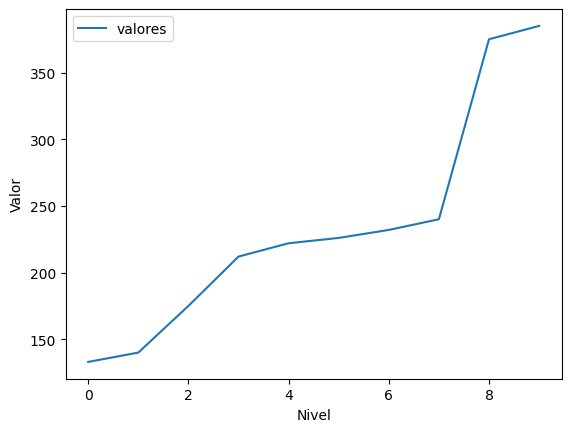

In [42]:
import matplotlib.pyplot as plt

plt.plot(df[1], label='valores')

plt.xlabel('Nivel')
plt.ylabel('Valor')
plt.legend()

plt.show()

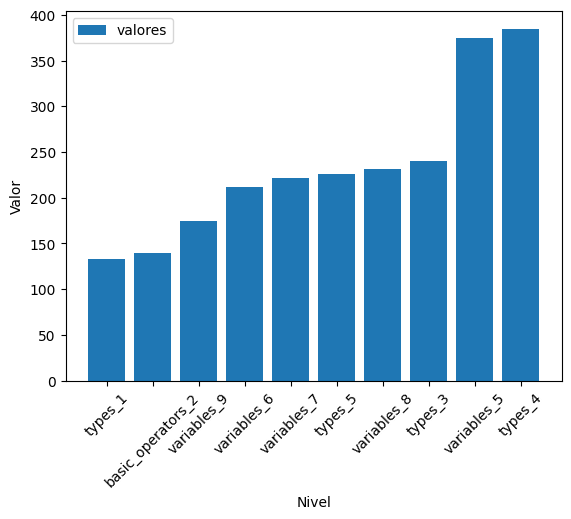

In [43]:
import matplotlib.pyplot as plt

plt.bar(df[0], df[1], label='valores')

plt.xlabel('Nivel')
plt.ylabel('Valor')
plt.legend()

plt.xticks(rotation=45)

plt.show()

In [44]:
df2 = pd.DataFrame(nivelesCreadas)
df1 = pd.DataFrame(valoresCreadas)

correlation = df.corrwith(df2)

print(correlation)

1    0.99142
dtype: float64


C:\Users\david\AppData\Local\Temp\ipykernel_19324\3337370289.py:4: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corrwith(df2)


In [45]:
import xml.etree.ElementTree as ET
code = "\r\n<xml>\r\n    <variables />\r\n    <block type=\"start_start\" id=\"start_start_vw37\" x=\"199\" y=\"-207\">\r\n        <next>\r\n            <block type=\"movement_move_laser\" id=\"movement_move_laser_r23d\">\r\n                <field name=\"DIRECTION\">UP</field>\r\n                <value name=\"AMOUNT\">\r\n                    <block type=\"math_number\" id=\"math_number_x823\">\r\n                        <field name=\"NUM\">1</field>\r\n                    </block>\r\n                </value>\r\n            </block>\r\n        </next>\r\n    </block>\r\n</xml>"

parsed = ET.fromstring(code)
#parsed.tag
#parsed.attrib

for child in parsed.iter():
    print(child.tag, child.attrib)

xml {}
variables {}
block {'type': 'start_start', 'id': 'start_start_vw37', 'x': '199', 'y': '-207'}
next {}
block {'type': 'movement_move_laser', 'id': 'movement_move_laser_r23d'}
field {'name': 'DIRECTION'}
value {'name': 'AMOUNT'}
block {'type': 'math_number', 'id': 'math_number_x823'}
field {'name': 'NUM'}
